# Bayes analysis of SIR model with changing points

## Libraries

In [1]:
# load libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma as gamma_func

from utils import *
from mcmc import *
from clustering import *
from regional_data_extractor import *


/home/vepe/miniconda3/envs/torch/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Veneto data 

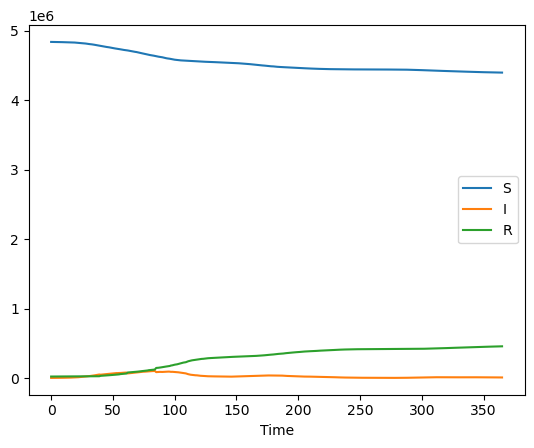

In [2]:
#load the Italian covid data
italian_data = pd.read_excel('ItalianData.xlsx')

#select the region of interest and the starting and ending date
sir_data = sir_data_extractor(italian_data, region='Veneto', start_date='2020-10-1', end_date='2021-10-1')

#crate the dataframw with the right variables for the SIR model
sir_dataframe = create_SIR_dataframe(sir_data)

#exctract the data into numpy array
S = sir_dataframe['S'].values
I = sir_dataframe['I'].values
R = sir_dataframe['R'].values
T = len(sir_dataframe)

plt.plot(S, label='S')
plt.plot(I, label='I')
plt.plot(R, label='R')
plt.xlabel('Time')
plt.ylabel('Number of individuals')
plt.legend()


## MCMC algorithm

### Data preparation

In [3]:
#Save initial conditions
S_0 = S[0]
I_0 = I[0]
R_0 = R[0]
N_0 = S_0 + I_0 + R_0
P_0 = I_0 / N_0

In [4]:
S = S[1:]
R = R[1:]
I = I[1:]

P = I / N_0

In [5]:
delta_R = R[1:] - R[:-1]
delta_R = np.concatenate([[R[0] - R_0], delta_R])

delta_I = S[:-1] - S[1:]
delta_I = np.concatenate([[S_0 - S[0]], delta_I])

print("Modified length: ", R.shape)
print("T: ", T)

Modified length:  (365,)
T:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 2

### MCMC hyper-parameter

In [6]:
N = 15_000  # n samplings
burnin = 5000
thinning = 10
p = 0.01

### Algorithm parameters

In [7]:
betas = np.zeros([N, T])
gammas = np.zeros([N, T])
bs = np.zeros([N, T])
rs = np.zeros([N, T])
deltas = np.zeros([N, T])

TypeError: only integer scalar arrays can be converted to a scalar index

In [14]:
# init
delta_0 = np.random.binomial(1, p, size=T) 
delta_0[0] = 1
K_0 = np.sum(delta_0) # Number of Changeing points
eta_0 = np.cumsum(delta_0) #Number of Changing points up to time t

# vectors of K elements
r_0 = np.random.gamma(shape=0.1, scale=10, size=K_0)
b_0 = np.random.gamma(shape=0.1, scale=10, size=K_0)

r_0 = r_0[eta_0-1]
b_0 = b_0[eta_0-1]

beta_0 = np.random.exponential(1/b_0)
gamma_0 = np.random.beta(r_0, 1)

In [15]:
delta = delta_0.copy()
beta = beta_0.copy()
gamma = gamma_0.copy()
r = r_0.copy()
b = b_0.copy()

### Simulation

In [16]:
from tqdm.notebook import tqdm

In [17]:
K = np.sum(delta)
eta = np.cumsum(delta)
for n in tqdm(range(N)):

    delta_ = propose_delta(delta, T)
    delta = accept_delta(delta, delta_, beta, gamma, T, p)

    b = update_b(delta, beta)
    r = update_r(delta, gamma)

    beta = update_beta(delta, T, S_0, P_0, S, P, delta_I)
    gamma = update_gamma(r, T, I_0, I, delta_R)

    betas[n, :] = beta
    gammas[n, :] = gamma
    deltas[n, :] = delta
    rs[n, :] = r
    bs[n, :] = b

  0%|          | 0/15000 [00:00<?, ?it/s]

## Analysis of data

In [18]:
beta_samples = betas[burnin::thinning, :]
delta_samples = deltas[burnin::thinning, :]
b_samples = bs[burnin::thinning, :]
r_samples = rs[burnin::thinning, :]

eta_samples = np.cumsum(delta_samples, axis=1)

n_samples = eta_samples.shape[0]
q = np.zeros((T, T))
for n in range(n_samples):
    q += (eta_samples[n, :] == (eta_samples[n, :])[:, None]).astype(int)
q = q / n_samples

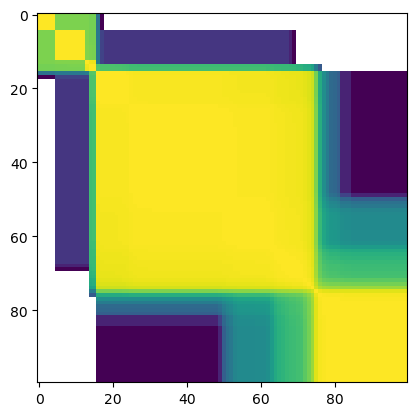

In [19]:
import matplotlib.colors as col
plt.imshow(q, norm = 'log')


### Clustering

In [20]:
delta_hat = np.array([0] * T)
delta_hat[0] = 1


eta_hat = np.cumsum(delta_hat)

continue_add = True
continue_swap = True

In [21]:
delta_final = clustering(delta_hat, eta_hat, q, T, continue_add, continue_swap)

### Changing points 

In [22]:
eta_final= np.cumsum(delta_final)
K_final= np.sum(delta_final)

tau_final= np.where(delta_final==1)[0]

In [23]:
tau_final

array([ 0,  5, 13, 16, 75])

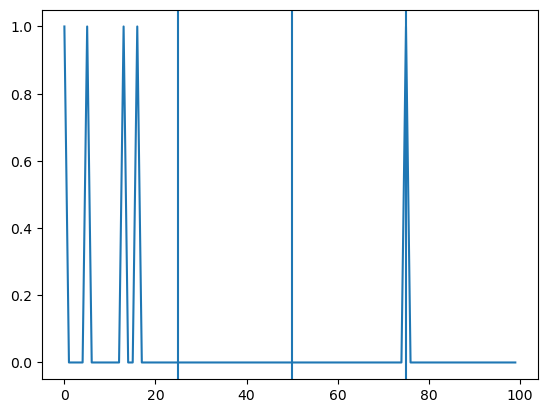

In [24]:
plt.plot(delta_final)
plt.axvline(25)
plt.axvline(75)
plt.axvline(50)

### Confidence intervals

In [25]:
alpha=0.05

In [26]:
def constraint_lhs(deltas, tau_l, tau_u):
    n_samples = deltas.shape[0]
    sum_tau = np.sum(deltas[:, tau_l:tau_u]) / n_samples
    return sum_tau

In [27]:
def possible_taus(tau_k, delta_tau):
    lower= tau_k
    upper= tau_k +delta_tau
    possible=[]
    for i in range(delta_tau+1):
        if upper<=T and lower>=0:
            possible.append((lower, upper))
            lower-=1
            upper-=1
    return possible

# possible_taus(4, 4)

In [28]:
ci_tau = []
for tau_k in tau_final:
    for delta_tau in range(2, T):
        candidate = []
        possible_taus_list = possible_taus(tau_k, delta_tau)
        for tau_l, tau_u in possible_taus_list:
            sum_tau = constraint_lhs(delta_samples, tau_l, tau_u)
            if sum_tau >= 1 - alpha:
                candidate.append([sum_tau, tau_l, tau_u])
        if len(candidate) > 0:
            break

    if len(candidate) == 0:
        ci_tau.append(np.array([0, T]))
    else:
        candidate = np.array(candidate)
        index_max_candidate = np.argmax(candidate[:, 0])
        ci_tau.append(candidate[index_max_candidate, 1:])

### Final Beta and Gamma

In [29]:
sum_beta = np.zeros(T)
sum_gamma = np.zeros(T)
n_smaples_reduced = delta_samples.shape[0]
for g in range(n_smaples_reduced):
    sum_beta += 1 / b_samples[g, :]
    sum_gamma+= r_samples[g, :]/(1+r_samples[g, :])
beta_final = sum_beta / n_smaples_reduced
gamma_final = sum_gamma / n_smaples_reduced

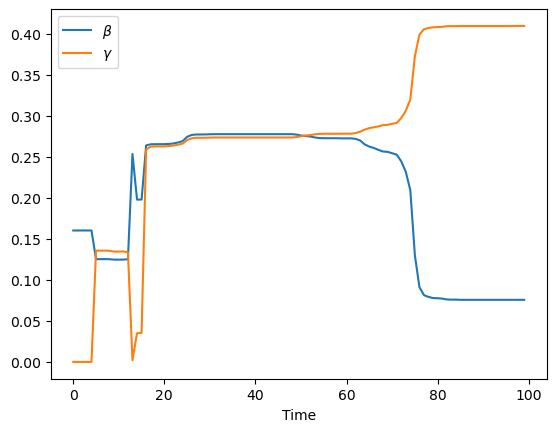

In [44]:
plt.plot(beta_final, label=r'$\beta$')
plt.plot(gamma_final, label=r'$\gamma$')
plt.xlabel('Time')
plt.legend()

## Bayesian analysis     

#### Plots

In [35]:
posterior_frequency = np.sum(delta_samples[:, 1:], axis = 0)/n_samples

Text(0.5, 0, 'Time[Days]')

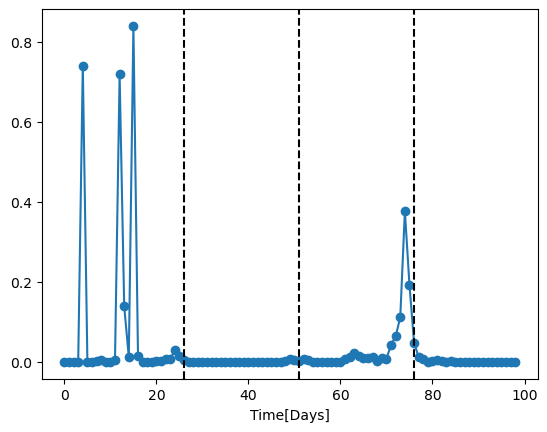

In [36]:
plt.plot(posterior_frequency, 'o-')
for gt in gt_changing_points[1:]:
    plt.axvline(gt, linestyle = '--', c = 'k')



plt.xlabel('Time[Days]')

#### Changing Points

In [37]:
K_final = np.sum(delta_final)

In [38]:
tau_final

array([ 0,  5, 13, 16, 75])

In [39]:
ci_tau

[array([0., 2.]),
 array([0., 5.]),
 array([13., 17.]),
 array([14., 17.]),
 array([63., 79.])]

### Metrics

#### ARI

In [40]:
TP = 0
FP = 0
FN = 0
TN = 0
for i in range(T):
    for j in range(i+1, T):
        TP = TP + int(eta_final[i]==eta_final[j] and gt_eta[i]==gt_eta[j])
        FP = FP + int(eta_final[i]!=eta_final[j] and gt_eta[i]==gt_eta[j])
        FN = FN + int(eta_final[i]==eta_final[j] and gt_eta[i]!=gt_eta[j])
        TN = TN + int(eta_final[i]!=eta_final[j] and gt_eta[i]!=gt_eta[j])

TP = TP*2/(T*(T-1))
FP = FP*2/(T*(T-1))
FN = FN*2/(T*(T-1))
TN = TN*2/(T*(T-1))

In [41]:
ARI = (TP + TN - ((TP+FP)*(TP+FN)+(TN+FP)*(TN+FN)))/(1-((TP+FP)*(TP+FN) + (TN+FP)*(TN+FN)))
print('ARI:', ARI)

ARI: 0.42492347349766413


#### Mutual information  (NON sono definiti k1 e k2)

In [42]:
MI = 0


for k1 in range(int(K_final)):
    for k2 in range(int(K_final)):
        n_k1 = np.sum(gt_eta == k1)
        n_k2 = np.sum(eta_final == k2)
        n_k1k2 = np.sum((gt_eta == k1) & (eta_final == k2))
        if n_k1k2 > 0:
            MI += n_k1k2/T * (np.log(T * n_k1k2) - np.log(n_k1 * n_k2))

In [43]:
print('MI:', MI)

MI: 0.44116180332990373
